In [5]:
"""
Garden Planner - Plant Recommendation System (Vectorized & Optimized)
Recommends suitable plants based on location-specific environmental data
"""

import sqlite3
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass
from datetime import datetime, timedelta
import warnings

import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim
from meteostat import Point, Daily

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import io
import re

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Application configuration"""
    DB_PATH = "garden_planner.db"
    DATA_DIR = Path("data")
    RAW_DATA_DIR = DATA_DIR / "raw"
    PROCESSED_DATA_DIR = DATA_DIR / "processed"
    
    # API timeouts
    API_TIMEOUT = 10
    
    # Climate scenarios
    CLIMATE_SCENARIOS = {
        'current': {'year': 2025, 'temp_offset': 0, 'precip_factor': 1.0, 'frost_factor': 1.0},
        'rcp45_2050': {'year': 2050, 'temp_offset': 1.5, 'precip_factor': 0.95, 'frost_factor': 0.7},
        'rcp85_2100': {'year': 2100, 'temp_offset': 3.5, 'precip_factor': 0.85, 'frost_factor': 0.4},
    }
    
    # Scoring weights
    WEIGHTS = {
        'hardiness': 0.4,
        'shade': 0.15,
        'moisture': 0.15,
        'soil': 0.25,
        'physical': 0.20,
        'usefulness': 0.10,
    }


# ============================================================================
# DATA MODELS
# ============================================================================

@dataclass
class Location:
    """Location data model"""
    name: str
    lat: float
    lon: float
    altitude: int = 0
    microclimate: str = "plain"
    soil_type: str = "neutral_loam"
    soil_ph: float = 6.5
    geology: str = "unknown"
    subsurface_water: float = 2.0
    country: str = "Unknown"
    region: str = "Unknown"
    city: str = "Unknown"


@dataclass
class ClimateData:
    """Climate data model"""
    location_id: int
    year: int
    scenario: str
    avg_temp: float
    min_temp: float
    max_temp: float
    precip: float
    frost_days: int


# ============================================================================
# DATABASE MANAGER
# ============================================================================

class DatabaseManager:
    """Handles all database operations"""
    
    def __init__(self, db_path: str = Config.DB_PATH):
        self.db_path = db_path
        self._ensure_directories()
    
    def _ensure_directories(self):
        """Create necessary directories"""
        Config.RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
        Config.PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
        Path(self.db_path).touch(exist_ok=True)
    
    def get_connection(self) -> sqlite3.Connection:
        """Get database connection"""
        return sqlite3.connect(self.db_path)
    
    def create_schema(self, plant_csv_path: str):
        """Create database schema dynamically from CSV"""
        df = pd.read_csv(plant_csv_path)
        columns = df.columns.tolist()
        columns_def = ', '.join([f'"{col}" TEXT' for col in columns])
        
        with self.get_connection() as conn:
            cursor = conn.cursor()
            
            # Plants table (dynamic from CSV)
            cursor.execute(f'''
                CREATE TABLE IF NOT EXISTS plants (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    {columns_def}
                )
            ''')
            
            # Locations table
            cursor.execute('''
                CREATE TABLE IF NOT EXISTS locations (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    name TEXT NOT NULL,
                    lat REAL NOT NULL,
                    lon REAL NOT NULL,
                    altitude INTEGER,
                    microclimate TEXT,
                    soil_type TEXT,
                    soil_ph REAL,
                    geology TEXT,
                    subsurface_water REAL,
                    country TEXT,
                    region TEXT,
                    city TEXT,
                    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                )
            ''')
            
            # Climate data table
            cursor.execute('''
                CREATE TABLE IF NOT EXISTS climate_data (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    location_id INTEGER,
                    year INTEGER,
                    avg_temp REAL,
                    min_temp REAL,
                    max_temp REAL,
                    precip REAL,
                    frost_days INTEGER,
                    scenario TEXT,
                    FOREIGN KEY (location_id) REFERENCES locations (id)
                )
            ''')
            
            # Recommendations table
            cursor.execute('''
                CREATE TABLE IF NOT EXISTS recommendations (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    location_id INTEGER,
                    plant_id INTEGER,
                    suitability_score REAL,
                    reasons TEXT,
                    companions_suggested TEXT,
                    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                    FOREIGN KEY (location_id) REFERENCES locations (id),
                    FOREIGN KEY (plant_id) REFERENCES plants (id)
                )
            ''')
            
            conn.commit()
    
    def load_plants(self, csv_path: str) -> int:
        """Load plants from CSV"""
        df = pd.read_csv(csv_path)
        with self.get_connection() as conn:
            df.to_sql('plants', conn, if_exists='replace', index=False)
        return len(df)
    
    def save_location(self, location: Location) -> int:
        """Save location and return its ID"""
        with self.get_connection() as conn:
            cursor = conn.cursor()
            cursor.execute('''
                INSERT INTO locations 
                (name, lat, lon, altitude, microclimate, soil_type, soil_ph, 
                 geology, subsurface_water, country, region, city)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (
                location.name, location.lat, location.lon, location.altitude,
                location.microclimate, location.soil_type, location.soil_ph,
                location.geology, location.subsurface_water, location.country,
                location.region, location.city
            ))
            conn.commit()
            return cursor.lastrowid
    
    def save_climate_data(self, climate_records: List[ClimateData]):
        """Save climate data records"""
        records = [
            (c.location_id, c.year, c.avg_temp, c.min_temp, c.max_temp, 
             c.precip, c.frost_days, c.scenario)
            for c in climate_records
        ]
        
        with self.get_connection() as conn:
            cursor = conn.cursor()
            cursor.executemany('''
                INSERT INTO climate_data 
                (location_id, year, avg_temp, min_temp, max_temp, precip, frost_days, scenario)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?)
            ''', records)
            conn.commit()


# ============================================================================
# LOCATION DATA FETCHER
# ============================================================================

class LocationDataFetcher:
    """Fetches real geographic and environmental data from APIs"""
    
    @staticmethod
    def fetch_altitude(lat: float, lon: float) -> int:
        """Fetch altitude from Open-Elevation API"""
        try:
            url = f"https://api.open-elevation.com/api/v1/lookup?locations={lat},{lon}"
            response = requests.get(url, timeout=Config.API_TIMEOUT)
            if response.status_code == 200:
                return round(response.json()['results'][0]['elevation'])
        except Exception as e:
            print(f"⚠️ Altitude fetch failed: {e}")
        return 0
    
    @staticmethod
    def fetch_address(lat: float, lon: float) -> Dict[str, str]:
        """Fetch address information via reverse geocoding"""
        try:
            geolocator = Nominatim(user_agent="garden_planner_v2")
            location = geolocator.reverse((lat, lon), timeout=Config.API_TIMEOUT)
            if location:
                return location.raw.get('address', {})
        except Exception as e:
            print(f"⚠️ Geocoding failed: {e}")
        return {}
    
    @staticmethod
    def fetch_soil_ph(lat: float, lon: float) -> float:
        """Fetch soil pH from OpenLandMap"""
        try:
            url = f"https://api.openlandmap.org/soil?lat={lat}&lon={lon}&parameter_id=gnap&value=mean"
            response = requests.get(url, timeout=Config.API_TIMEOUT)
            if response.status_code == 200:
                return round(response.json()['data'][0][0], 1)
        except Exception as e:
            print(f"⚠️ Soil pH fetch failed: {e}")
        return 6.5
    
    @staticmethod
    def fetch_geology(lat: float, lon: float) -> str:
        """Fetch geology information from Macrostrat"""
        try:
            url = f"https://macrostrat.org/api/v2/point/lith?lat={lat}&lng={lon}"
            response = requests.get(url, timeout=Config.API_TIMEOUT)
            data = response.json()
            if response.status_code == 200 and data.get('success'):
                return data['data'][0]['lith'][:50]
        except Exception as e:
            print(f"⚠️ Geology fetch failed: {e}")
        return "unknown"
    
    @staticmethod
    def infer_microclimate(altitude: int) -> str:
        """Infer microclimate from altitude"""
        if altitude > 1000:
            return "mountain"
        elif altitude > 300:
            return "hilly"
        elif altitude > 100:
            return "foothills"
        return "plain"
    
    @staticmethod
    def infer_soil_type(ph: float) -> str:
        """Infer soil type from pH"""
        if ph < 6.0:
            return "acidic"
        elif ph > 7.5:
            return "alkaline"
        return "neutral_loam"
    
    def fetch_location_data(self, lat: float, lon: float, name: str = "My Garden") -> Location:
        """Fetch all location data and return Location object"""
        print(f"🌍 Fetching data for {name} ({lat:.4f}, {lon:.4f})...")
        
        altitude = self.fetch_altitude(lat, lon)
        address = self.fetch_address(lat, lon)
        soil_ph = self.fetch_soil_ph(lat, lon)
        geology = self.fetch_geology(lat, lon)
        
        location = Location(
            name=name,
            lat=lat,
            lon=lon,
            altitude=altitude,
            microclimate=self.infer_microclimate(altitude),
            soil_type=self.infer_soil_type(soil_ph),
            soil_ph=soil_ph,
            geology=geology,
            subsurface_water=2.0,
            country=address.get('country', 'Unknown'),
            region=address.get('region', 'Unknown'),
            city=address.get('city', address.get('town', 'Unknown'))
        )
        
        print("✅ Location data fetched:")
        for key, value in location.__dict__.items():
            print(f"   {key}: {value}")
        
        return location


# ============================================================================
# CLIMATE DATA FETCHER
# ============================================================================

class ClimateDataFetcher:
    """Fetches and processes climate data"""
    
    def fetch_historical_climate(self, lat: float, lon: float, 
                                start_year: int = 2015, 
                                end_year: int = 2024) -> pd.DataFrame:
        """Fetch historical climate data from Meteostat"""
        print(f"🌡️ Fetching climate data for ({lat:.4f}, {lon:.4f})...")
        
        location = Point(lat, lon)
        start = datetime(start_year, 1, 1)
        end = datetime(end_year, 12, 31)
        
        data = Daily(location, start, end)
        return data.fetch()
    
    def generate_climate_scenarios(self, location_id: int, lat: float, lon: float) -> List[ClimateData]:
        """Generate climate scenarios (historical + projections)"""
        df = self.fetch_historical_climate(lat, lon)
        
        if df.empty:
            print("⚠️ No climate data available, using defaults")
            return self._default_climate_data(location_id)
        
        # Calculate baseline statistics
        avg_temp = df['tavg'].mean()
        min_temp = df['tmin'].min()
        max_temp = df['tmax'].max()
        precip = df['prcp'].sum() / len(df.index.year.unique())  # Annual average
        frost_days = (df['tmin'] <= 0).sum() / len(df.index.year.unique())
        
        climate_records = []
        
        for scenario_name, params in Config.CLIMATE_SCENARIOS.items():
            climate_records.append(ClimateData(
                location_id=location_id,
                year=params['year'],
                scenario=scenario_name,
                avg_temp=round(avg_temp + params['temp_offset'], 1),
                min_temp=round(min_temp + params['temp_offset'] * 0.7, 1),
                max_temp=round(max_temp + params['temp_offset'] * 1.3, 1),
                precip=round(precip * params['precip_factor'], 0),
                frost_days=int(frost_days * params['frost_factor'])
            ))
        
        print(f"✅ Generated {len(climate_records)} climate scenarios")
        return climate_records
    
    def _default_climate_data(self, location_id: int) -> List[ClimateData]:
        """Default climate data for Sofia-like conditions"""
        return [
            ClimateData(location_id, 2025, 'current', 12.0, -15.0, 35.0, 600.0, 60),
            ClimateData(location_id, 2050, 'rcp45_2050', 13.5, -13.0, 37.0, 570.0, 42),
            ClimateData(location_id, 2100, 'rcp85_2100', 15.5, -11.0, 39.5, 510.0, 24),
        ]


# ============================================================================
# VECTORIZED PLANT SUITABILITY CALCULATOR
# ============================================================================

class VectorizedPlantSuitabilityCalculator:
    """VECTORIZED version - calculates all plants at once using NumPy operations"""
    
    def __init__(self, db: DatabaseManager):
        self.db = db
    
    def calculate_suitability(self, location_id: int, 
                            top_n: int = 20, 
                            min_score: float = 0.3) -> pd.DataFrame:
        """Calculate suitability scores for all plants using vectorization"""
        print(f"🌱 Calculating plant suitability (VECTORIZED) for location {location_id}...")
        
        with self.db.get_connection() as conn:
            # Get location data
            location = pd.read_sql(
                f"SELECT * FROM locations WHERE id = {location_id}", conn
            ).iloc[0]
            
            # Get climate data
            climate = pd.read_sql(
                f"""SELECT * FROM climate_data 
                    WHERE location_id = {location_id} AND scenario = 'current'
                    LIMIT 1""", conn
            )
            
            if climate.empty:
                print("⚠️ No climate data found, using defaults")
                climate_data = {'avg_temp': 12.0, 'frost_days': 60, 'precip': 600}
            else:
                climate_data = climate.iloc[0].to_dict()
            
            # Get all plants as DataFrame (keep in pandas for vectorization)
            plants = pd.read_sql("SELECT * FROM plants", conn)
        
        # VECTORIZED SCORING - process all plants at once
        scores_df = self._vectorized_score_all_plants(plants, location, climate_data)
        
        # Filter and sort
        scores_df = scores_df[scores_df['suitability_score'] >= min_score]
        scores_df = scores_df.sort_values('suitability_score', ascending=False).head(top_n)
        
        # Save recommendations
        if not scores_df.empty:
            self._save_recommendations(location_id, scores_df)
        
        print(f"✅ Found {len(scores_df)} suitable plants")
        return scores_df
    
    def _vectorized_score_all_plants(self, plants: pd.DataFrame, 
                                    location: pd.Series, 
                                    climate: Dict) -> pd.DataFrame:
        """VECTORIZED: Score all plants at once using NumPy operations"""
        
        n_plants = len(plants)
        
        # Initialize score arrays
        total_scores = np.zeros(n_plants)
        
        # Extract location/climate values once
        avg_temp = climate['avg_temp']
        precip = climate['precip']
        frost_days = climate['frost_days']
        soil_ph = location['soil_ph']
        soil_type = location['soil_type']
        microclimate = location['microclimate']
        
        # ========== VECTORIZED HARDINESS SCORING ==========
        hardiness_scores = self._vectorized_hardiness(
            plants.get('hardiness', pd.Series([''] * n_plants)).fillna('').astype(str),
            avg_temp
        )
        total_scores += hardiness_scores * Config.WEIGHTS['hardiness']
        
        # ========== VECTORIZED SHADE SCORING ==========
        shade_scores = self._vectorized_shade(
            plants.get('shade', pd.Series([''] * n_plants)).fillna('').astype(str),
            avg_temp,
            precip
        )
        total_scores += shade_scores * Config.WEIGHTS['shade']
        
        # ========== VECTORIZED MOISTURE SCORING ==========
        moisture_scores = self._vectorized_moisture(
            plants.get('moisture', pd.Series([''] * n_plants)).fillna('').astype(str),
            precip
        )
        total_scores += moisture_scores * Config.WEIGHTS['moisture']
        
        # ========== VECTORIZED SOIL SCORING ==========
        soil_scores = self._vectorized_soil(
            plants.get('soil', pd.Series([''] * n_plants)).fillna('').astype(str),
            soil_type,
            soil_ph
        )
        total_scores += soil_scores * Config.WEIGHTS['soil']
        
        # ========== VECTORIZED PHYSICAL SCORING ==========
        physical_scores = self._vectorized_physical(
            plants.get('habit', pd.Series([''] * n_plants)).fillna('').astype(str),
            plants.get('growth', pd.Series([''] * n_plants)).fillna('').astype(str),
            microclimate
        )
        total_scores += physical_scores * Config.WEIGHTS['physical']
        
        # ========== VECTORIZED USEFULNESS SCORING ==========
        usefulness_scores = self._vectorized_usefulness(
            plants.get('edibility_rating', pd.Series([0] * n_plants)).fillna(0),
            plants.get('medicinal_rating', pd.Series([0] * n_plants)).fillna(0),
            plants.get('other_uses_rating', pd.Series([0] * n_plants)).fillna(0)
        )
        total_scores += usefulness_scores * Config.WEIGHTS['usefulness']
        
        # ========== VECTORIZED HAZARD PENALTY ==========
        hazards = plants.get('known_hazards', pd.Series([''] * n_plants)).fillna('').astype(str).str.lower()
        hazard_mask = hazards.str.contains('poison|toxic', na=False)
        total_scores = np.where(hazard_mask, total_scores * 0.7, total_scores)
        
        # ========== CREATE RESULTS DATAFRAME ==========
        results = pd.DataFrame({
            'plant_id': range(1, n_plants + 1),
            'latin_name': plants.get('latin_name', 'Unknown'),
            'common_name': plants.get('common_name', 'Unknown'),
            'suitability_score': np.round(total_scores, 3),
            'hardiness': plants.get('hardiness', ''),
            'habit': plants.get('habit', ''),
            'edibility': plants.get('edibility_rating', 0),
            'moisture': plants.get('moisture', 0),
            'soil': plants.get('soil', 0),
            'shade': plants.get('shade', 0),
            'medicinal': plants.get('medicinal_rating', 0),
            'reasons': self._generate_reasons_vectorized(
                hardiness_scores, soil_scores, hazard_mask
            )
        })
        
        return results
    
    def _vectorized_hardiness(self, hardiness_series: pd.Series, avg_temp: float) -> np.ndarray:
        """VECTORIZED: Score hardiness for all plants at once"""
        n = len(hardiness_series)
        scores = np.full(n, 0.5)  # Default score
        
        # Location zone
        location_zone = 6 + (avg_temp - 10) / 10
        
        # Extract zone ranges using vectorized string operations
        hardiness_clean = hardiness_series.str.replace('H', '', regex=False).str.strip()
        
        # Split zones and convert to numeric
        for idx, zone_str in enumerate(hardiness_clean):
            if not zone_str or zone_str == '':
                continue
            
            try:
                parts = zone_str.split('-')
                if len(parts) >= 2:
                    min_zone = float(parts[0])
                    max_zone = float(parts[1])
                    
                    if min_zone <= location_zone <= max_zone:
                        scores[idx] = 1.0
                    elif location_zone >= min_zone - 1:
                        scores[idx] = 0.7
                    else:
                        scores[idx] = 0.2
            except:
                pass
        
        return scores
    
    def _vectorized_shade(self, shade_series: pd.Series, avg_temp: float, precip: float) -> np.ndarray:
        """VECTORIZED: Score shade tolerance"""
        shade_lower = shade_series.str.lower()
        
        # Create boolean masks
        full_sun_mask = shade_lower.str.contains('full sun', na=False)
        shade_mask = shade_lower.str.contains('shade', na=False) & ~full_sun_mask
        
        # Vectorized scoring
        scores = np.full(len(shade_series), 0.8)  # Default
        scores = np.where(full_sun_mask, 1.0 if avg_temp > 10 else 0.8, scores)
        scores = np.where(shade_mask, 0.9 if precip > 700 else 0.7, scores)
        
        return scores
    
    def _vectorized_moisture(self, moisture_series: pd.Series, precip: float) -> np.ndarray:
        """VECTORIZED: Score moisture requirements"""
        moisture_lower = moisture_series.str.lower()
        
        # Create boolean masks
        moist_mask = moisture_lower.str.contains('moist|wet', na=False)
        dry_mask = moisture_lower.str.contains('dry', na=False)
        
        # Vectorized scoring
        scores = np.full(len(moisture_series), 0.8)  # Default
        scores = np.where(moist_mask, 1.0 if precip > 700 else 0.6, scores)
        scores = np.where(dry_mask, 1.0 if precip < 600 else 0.7, scores)
        
        return scores
    
    def _vectorized_soil(self, soil_series: pd.Series, soil_type: str, soil_ph: float) -> np.ndarray:
        """VECTORIZED: Score soil compatibility"""
        soil_lower = soil_series.str.lower()
        
        # Type matching
        loam_mask = soil_lower.str.contains('loam', na=False)
        acid_mask = soil_lower.str.contains('acid', na=False)
        alkal_mask = soil_lower.str.contains('alkal', na=False)
        
        scores = np.full(len(soil_series), 0.3)  # Default
        
        if 'loam' in soil_type:
            scores = np.where(loam_mask, 0.5, scores)
        if 'acidic' in soil_type:
            scores = np.where(acid_mask, 0.5, scores)
        if 'alkaline' in soil_type:
            scores = np.where(alkal_mask, 0.5, scores)
        
        # pH matching
        ph_bonus = np.zeros(len(soil_series))
        ph_bonus = np.where(acid_mask & (soil_ph < 6.5), 0.5, ph_bonus)
        ph_bonus = np.where(alkal_mask & (soil_ph > 7.0), 0.5, ph_bonus)
        ph_bonus = np.where((~acid_mask) & (~alkal_mask) & (soil_ph >= 6.0) & (soil_ph <= 7.5), 0.4, ph_bonus)
        
        scores = np.minimum(scores + ph_bonus, 1.0)
        
        return scores
    
    def _vectorized_physical(self, habit_series: pd.Series, growth_series: pd.Series, 
                           microclimate: str) -> np.ndarray:
        """VECTORIZED: Score physical characteristics"""
        habit_lower = habit_series.str.lower()
        growth_lower = growth_series.str.lower()
        
        # Habit scoring
        woody_mask = habit_lower.str.contains('shrub|tree', na=False)
        herb_mask = habit_lower.str.contains('perennial|annual', na=False)
        ground_mask = habit_lower.str.contains('ground cover', na=False)
        
        habit_scores = np.full(len(habit_series), 0.8)  # Default
        
        if microclimate in ['plain', 'foothills']:
            habit_scores = np.where(woody_mask, 0.9, habit_scores)
        else:
            habit_scores = np.where(woody_mask, 0.7, habit_scores)
        
        habit_scores = np.where(herb_mask, 1.0, habit_scores)
        habit_scores = np.where(ground_mask, 0.95, habit_scores)
        
        # Growth scoring
        fast_mask = growth_lower.str.contains('fast', na=False)
        medium_mask = growth_lower.str.contains('medium', na=False)
        
        growth_scores = np.full(len(growth_series), 0.6)  # Default
        growth_scores = np.where(fast_mask, 1.0, growth_scores)
        growth_scores = np.where(medium_mask, 0.8, growth_scores)
        
        return (habit_scores + growth_scores) / 2
    
    def _vectorized_usefulness(self, edibility: pd.Series, medicinal: pd.Series, 
                              other_uses: pd.Series) -> np.ndarray:
        """VECTORIZED: Score usefulness"""
        # Convert to numeric, handling any non-numeric values
        edib = pd.to_numeric(edibility, errors='coerce').fillna(0).values
        med = pd.to_numeric(medicinal, errors='coerce').fillna(0).values
        other = pd.to_numeric(other_uses, errors='coerce').fillna(0).values
        
        return (edib + med + other) / 3.0
    
    def _generate_reasons_vectorized(self, hardiness_scores: np.ndarray, 
                                    soil_scores: np.ndarray, 
                                    hazard_mask: pd.Series) -> pd.Series:
        """Generate reasons based on scores (simplified for vectorization)"""
        reasons_list = []
        
        for i in range(len(hardiness_scores)):
            reasons = []
            
            if hardiness_scores[i] >= 1.0:
                reasons.append("✅ Perfect hardiness")
            elif hardiness_scores[i] >= 0.7:
                reasons.append("⚠️ Marginal hardiness")
            
            if soil_scores[i] >= 0.7:
                reasons.append("✅ Good soil match")
            
            if hazard_mask.iloc[i]:
                reasons.append("⚠️ Known hazards")
            
            reasons_list.append('; '.join(reasons) if reasons else "Suitable conditions")
        
        return pd.Series(reasons_list)
    
    def _save_recommendations(self, location_id: int, results: pd.DataFrame):
        """Save recommendations to database"""
        with self.db.get_connection() as conn:
            results_copy = results.copy()
            results_copy['location_id'] = location_id
            results_copy[['location_id', 'plant_id', 'suitability_score', 'reasons']].to_sql(
                'recommendations', conn, if_exists='append', index=False
            )


# ============================================================================
# MAIN APPLICATION CLASS
# ============================================================================

class GardenPlanner:
    """Main application orchestrator"""
    
    def __init__(self, db_path: str = Config.DB_PATH, use_vectorized: bool = True):
        self.db = DatabaseManager(db_path)
        self.location_fetcher = LocationDataFetcher()
        self.climate_fetcher = ClimateDataFetcher()
        
        # Use vectorized calculator for better performance
        if use_vectorized:
            self.calculator = VectorizedPlantSuitabilityCalculator(self.db)
            print("🚀 Using VECTORIZED calculator for optimal performance")
        else:
            # Fallback to non-vectorized (not included in this version)
            raise NotImplementedError("Non-vectorized version not available")
    
    def initialize(self, plant_csv_path: str):
        """Initialize database and load plant data"""
        print("🚀 Initializing Garden Planner...")
        
        self.db.create_schema(plant_csv_path)
        count = self.db.load_plants(plant_csv_path)
        
        print(f"✅ Loaded {count} plants from {plant_csv_path}")
    
    def add_location(self, lat: float, lon: float, name: str = "My Garden") -> int:
        """Add a new garden location with real environmental data"""
        # Fetch location data
        location = self.location_fetcher.fetch_location_data(lat, lon, name)
        
        # Save to database
        location_id = self.db.save_location(location)
        
        # Fetch and save climate data
        climate_data = self.climate_fetcher.generate_climate_scenarios(location_id, lat, lon)
        self.db.save_climate_data(climate_data)
        
        print(f"✅ Location '{name}' added with ID: {location_id}")
        return location_id
    
    def get_recommendations(self, location_id: int, top_n: int = 100, 
                          min_score: float = 0.5) -> pd.DataFrame:
        """Get plant recommendations for a location"""
        results = self.calculator.calculate_suitability(location_id, top_n, min_score)
        
        if not results.empty:
            print("\n🎯 TOP RECOMMENDATIONS:")
            print(results[['latin_name', 'common_name', 'suitability_score']].to_string(index=False))
        
        return results
    
    def export_recommendations(self, location_id: int, filepath: str):
        """Export recommendations to CSV"""
        results = self.get_recommendations(location_id)
        results.to_csv(filepath, index=False)
        print(f"📄 Exported to {filepath}")
    
    def benchmark_performance(self, location_id: int):
        """Benchmark the vectorized performance"""
        import time
        
        print("\n⚡ PERFORMANCE BENCHMARK ⚡")
        start = time.time()
        results = self.calculator.calculate_suitability(location_id, top_n=100, min_score=0.0)
        elapsed = time.time() - start
        
        print(f"✅ Processed {len(results)} plants in {elapsed:.3f} seconds")
        print(f"📊 Performance: {len(results)/elapsed:.1f} plants/second")


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

if __name__ == "__main__":
    # Initialize the garden planner with vectorized calculator
    planner = GardenPlanner(use_vectorized=True)
    planner.initialize('pfaf2.csv')
    
    # Add garden locations
    sofia_id = planner.add_location(42.6977, 23.3219, "Sofia Garden")
    
    # Get recommendations
    recommendations = planner.get_recommendations(sofia_id, top_n=15, min_score=0.5)
    
    # Export results
    planner.export_recommendations(sofia_id, 'sofia_recommendations.csv')
    
    # Benchmark performance
    planner.benchmark_performance(sofia_id)
    
    # Verify database
    with planner.db.get_connection() as conn:
        print("\n📊 DATABASE SUMMARY:")
        print("Plants:", pd.read_sql("SELECT COUNT(*) as count FROM plants", conn).iloc[0]['count'])
        print("Locations:", pd.read_sql("SELECT COUNT(*) as count FROM locations", conn).iloc[0]['count'])
        print("Climate data:", pd.read_sql("SELECT COUNT(*) as count FROM climate_data", conn).iloc[0]['count'])
        print("\nLocations:")
        print(pd.read_sql("SELECT name, lat, lon, altitude, soil_ph FROM locations", conn).to_string(index=False))

🚀 Using VECTORIZED calculator for optimal performance
🚀 Initializing Garden Planner...
✅ Loaded 8505 plants from pfaf2.csv
🌍 Fetching data for Sofia Garden (42.6977, 23.3219)...
✅ Location data fetched:
   name: Sofia Garden
   lat: 42.6977
   lon: 23.3219
   altitude: 556
   microclimate: hilly
   soil_type: neutral_loam
   soil_ph: 6.5
   geology: unknown
   subsurface_water: 2.0
   country: България
   region: Unknown
   city: София
🌡️ Fetching climate data for (42.6977, 23.3219)...
✅ Generated 3 climate scenarios
✅ Location 'Sofia Garden' added with ID: 3
🌱 Calculating plant suitability (VECTORIZED) for location 3...
✅ Found 15 suitable plants

🎯 TOP RECOMMENDATIONS:
                latin_name                                          common_name  suitability_score
             Urtica dioica                   Stinging Nettle, California nettle              1.442
       Althaea officinalis                     Marsh Mallow, Common marshmallow              1.408
   Pueraria montana lob

✅ Found 100 suitable plants
✅ Processed 100 plants in 0.282 seconds
📊 Performance: 354.5 plants/second

📊 DATABASE SUMMARY:
Plants: 8505
Locations: 3
Climate data: 9

Locations:
        name     lat     lon  altitude  soil_ph
Sofia Garden 42.6977 23.3219       556      6.5
Sofia Garden 42.6977 23.3219       556      6.5
Sofia Garden 42.6977 23.3219       556      6.5


C:\Users\PC\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\PC\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\PC\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\PC\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is k

Total final clusters: 28 (max size 5)

================= CLUSTERS (≤5 plants each) =================

Cluster 0 (size=5):
  - Perennial cereal rye
  - Filbert, Giant filbert
  - Ramanas Rose, Rugosa rose
  - Siberian Pea Tree, Siberian peashrub
  - Musk Mallow

Cluster 1 (size=3):
  - Kudzu Vine
  - Midland Hawthorn, Smooth hawthorn, English  Hawthorn
  - Hop, Common hop, European Hop,

Cluster 2 (size=5):
  - Partridge Berry
  - Wild Thyme
  - Rosemary
  - Scot's Pine, Scotch Pine
  - Hyssop

Cluster 3 (size=1):
  - Bearberry

Cluster 4 (size=4):
  - Carrot
  - Sweet Corn,  	Corn
  - Oriental Radish
  - Caraway

Cluster 5 (size=7):
  - Yarrow, Boreal yarrow, California yarrow, Giant yarrow, Coast yarrow, Western yarrow, Pacific yarrow
  - Greek Oregano
  - Juniper, Common juniper
  - European Barberry, Common barberry
  - Creeping Oregon Grape, Creeping barberry, Grape Oregon
  - Hybrid poplar
  - Juniper

Cluster 6 (size=2):
  - English Lavender, True Lavender
  - Sweet Marjoram

Clu

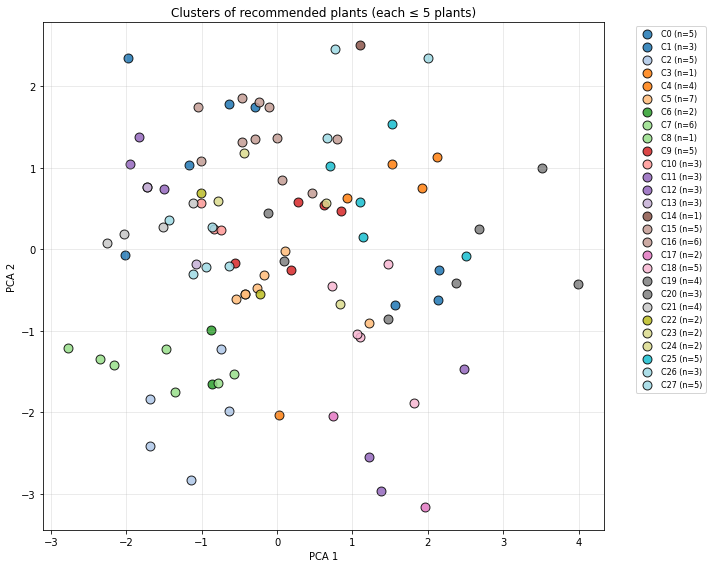

C:\Users\PC\AppData\Local\Temp\ipykernel_8560\2459677340.py:159: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_source = suit["Source_clean"].str.contains(pattern, na=False)
C:\Users\PC\AppData\Local\Temp\ipykernel_8560\2459677340.py:160: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_dest = suit["Dest_clean"].str.contains(pattern, na=False)
C:\Users\PC\AppData\Local\Temp\ipykernel_8560\2459677340.py:159: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_source = suit["Source_clean"].str.contains(pattern, na=False)
C:\Users\PC\AppData\Local\Temp\ipykernel_8560\2459677340.py:160: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mas


Excel report saved as Sofia_Garden_results.xlsx


In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# =====================================================================
# Configuration
# =====================================================================
MAX_SIZE = 5  # maximum plants per final cluster
GARDEN_NAME = "Sofia_Garden"  # garden name for output file

# =====================================================================
# 1. Load and prepare data
# =====================================================================
df = pd.read_csv("sofia_recommendations.csv")
df = df.sort_values("suitability_score", ascending=False).head(100)

trait_cols = ["hardiness", "habit", "soil", "shade", "moisture",
              "edibility", "medicinal", "suitability_score"]
X_raw = df[trait_cols].copy()

# =====================================================================
# 2. Encode and scale features
# =====================================================================
def prepare_features(X: pd.DataFrame) -> np.ndarray:
    """Encode categorical features and scale numerical features."""
    X = X.copy().fillna("unknown")
    
    # Encode categorical columns
    for col in X.select_dtypes(include=["object"]).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    
    # Scale numerical columns
    scaler = StandardScaler()
    num_cols = X.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        X[num_cols] = scaler.fit_transform(X[num_cols])
    
    return X.values

X = prepare_features(X_raw)

# =====================================================================
# 3. Two-stage clustering to ensure max size per cluster
# =====================================================================
n_plants = len(df)
k_coarse = max(1, n_plants // MAX_SIZE)

# Coarse clustering
kmeans = KMeans(n_clusters=k_coarse, random_state=42, n_init=10)
df["coarse_cluster"] = kmeans.fit_predict(X)

# Split large clusters
final_cluster_labels = np.zeros(n_plants, dtype=int)
current_label = 0

for cc in sorted(df["coarse_cluster"].unique()):
    idx = np.where(df["coarse_cluster"].values == cc)[0]
    group_size = len(idx)
    
    if group_size <= MAX_SIZE:
        final_cluster_labels[idx] = current_label
        current_label += 1
    else:
        sub_k = int(np.ceil(group_size / MAX_SIZE))
        k_sub = KMeans(n_clusters=sub_k, random_state=42, n_init=10)
        sub_labels = k_sub.fit_predict(X[idx])
        
        for s in range(sub_k):
            idx_sub = idx[sub_labels == s]
            final_cluster_labels[idx_sub] = current_label
            current_label += 1

df["cluster"] = final_cluster_labels
n_final = df["cluster"].nunique()
print(f"Total final clusters: {n_final} (max size {MAX_SIZE})")

# =====================================================================
# 4. Print cluster contents
# =====================================================================
print("\n================= CLUSTERS (≤5 plants each) =================")
for c in sorted(df["cluster"].unique()):
    group = df[df["cluster"] == c]
    names = group["common_name"].fillna(group["latin_name"])
    print(f"\nCluster {c} (size={len(group)}):")
    for name in names:
        print("  -", name)

# =====================================================================
# 5. Create visualization
# =====================================================================
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.tab20(np.linspace(0, 1, n_final))

for i, c in enumerate(sorted(df["cluster"].unique())):
    mask = df["cluster"] == c
    ax.scatter(
        X_2d[mask, 0],
        X_2d[mask, 1],
        s=80,
        c=[colors[i]],
        alpha=0.85,
        edgecolors="black",
        label=f"C{c} (n={mask.sum()})"
    )

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_title("Clusters of recommended plants (each ≤ 5 plants)")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plant_clusters_max5.png", dpi=300, bbox_inches="tight")
plt.show()

# =====================================================================
# 6. Load and process companion plant suitability data
# =====================================================================
def clean_name(s: str) -> str:
    """Normalize plant names for matching."""
    if pd.isna(s):
        return ""
    s = s.split(",")[0].strip().lower()
    if len(s) > 3 and s.endswith("ies"):
        s = s[:-3] + "y"
    elif len(s) > 2 and s.endswith("es"):
        s = s[:-2]
    elif len(s) > 1 and s.endswith("s"):
        s = s[:-1]
    return s

# Load companion plants data
suit = pd.read_csv("companion_plants.csv")
suit["Source_clean"] = suit["Source Node"].astype(str).apply(clean_name)
suit["Dest_clean"] = suit["Destination Node"].astype(str).apply(clean_name)

# Clean cluster plant names
df["name_clean"] = df["common_name"].apply(clean_name)

# Build suitability tables per cluster
cluster_suit_tables = {}

for cl in sorted(df["cluster"].unique()):
    sub = df[df["cluster"] == cl]
    names = [n for n in sub["name_clean"].tolist() if n]
    if not names:
        continue
    
    pattern = "(" + "|".join(re.escape(n) for n in names) + ")"
    
    mask_source = suit["Source_clean"].str.contains(pattern, na=False)
    mask_dest = suit["Dest_clean"].str.contains(pattern, na=False)
    match_rows = suit[mask_source & mask_dest]
    
    cluster_suit_tables[cl] = match_rows[["Source Node", "Link",
                                          "Destination Node", "Source Type"]]

# =====================================================================
# 7. Export results to Excel
# =====================================================================
# Prepare cluster dataframe
cluster_df = df[[
    "plant_id", "latin_name", "common_name", "suitability_score",
    "hardiness", "habit", "soil", "shade", "moisture",
    "edibility", "medicinal", "cluster"
]].copy()

with pd.ExcelWriter(f"{GARDEN_NAME}_results.xlsx", engine="xlsxwriter") as writer:
    # Main clusters sheet
    cluster_df.to_excel(writer, sheet_name="clusters", index=False)
    
    # Suitability sheets per cluster
    for cl, df_cl in cluster_suit_tables.items():
        sheet_name = f"cluster_{cl}"
        df_cl.to_excel(writer, sheet_name=sheet_name, index=False)
    
    # Add visualization sheet
    workbook = writer.book
    ws_plot = workbook.add_worksheet("clusters_plot")
    ws_plot.write(0, 0, f"Garden: {GARDEN_NAME}")
    
    img = io.BytesIO()
    fig.savefig(img, format="png", dpi=200, bbox_inches="tight")
    img.seek(0)
    ws_plot.insert_image("B3", "", {"image_data": img})

print(f"\nExcel report saved as {GARDEN_NAME}_results.xlsx")

C:\Users\PC\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\PC\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\PC\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\PC\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is k

Total final clusters: 28 (max size 5)

================= CLUSTERS (≤5 plants each) =================

Cluster 0 (size=5):
  - Perennial cereal rye
  - Filbert, Giant filbert
  - Ramanas Rose, Rugosa rose
  - Siberian Pea Tree, Siberian peashrub
  - Musk Mallow

Cluster 1 (size=3):
  - Kudzu Vine
  - Midland Hawthorn, Smooth hawthorn, English  Hawthorn
  - Hop, Common hop, European Hop,

Cluster 2 (size=5):
  - Partridge Berry
  - Wild Thyme
  - Rosemary
  - Scot's Pine, Scotch Pine
  - Hyssop

Cluster 3 (size=1):
  - Bearberry

Cluster 4 (size=4):
  - Carrot
  - Sweet Corn,  	Corn
  - Oriental Radish
  - Caraway

Cluster 5 (size=7):
  - Yarrow, Boreal yarrow, California yarrow, Giant yarrow, Coast yarrow, Western yarrow, Pacific yarrow
  - Greek Oregano
  - Juniper, Common juniper
  - European Barberry, Common barberry
  - Creeping Oregon Grape, Creeping barberry, Grape Oregon
  - Hybrid poplar
  - Juniper

Cluster 6 (size=2):
  - English Lavender, True Lavender
  - Sweet Marjoram

Clu

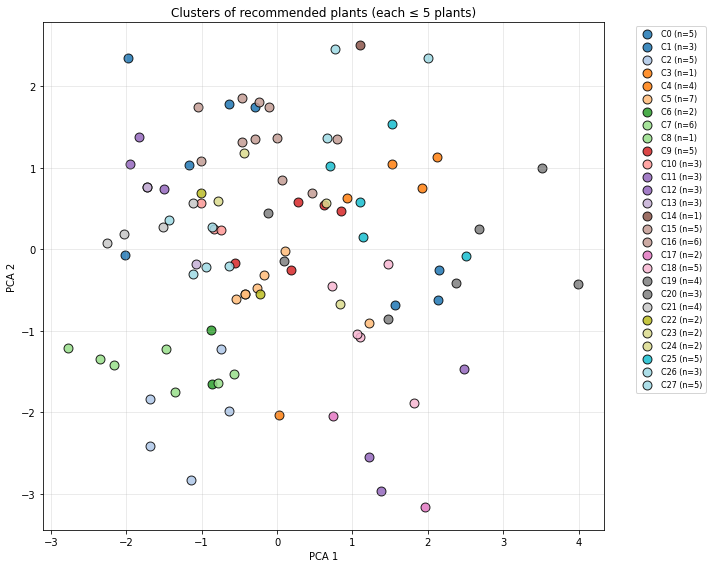


Cluster 2 has 1 companion relationships

Cluster 6 has 1 companion relationships

Cluster 19 has 1 companion relationships

Excel report saved as Sofia_Garden_results.xlsx


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# =====================================================================
# Configuration
# =====================================================================
MAX_SIZE = 5  # maximum plants per final cluster
GARDEN_NAME = "Sofia_Garden"  # garden name for output file

# =====================================================================
# 1. Load and prepare data
# =====================================================================
df = pd.read_csv("sofia_recommendations.csv")
df = df.sort_values("suitability_score", ascending=False).head(100)

trait_cols = ["hardiness", "habit", "soil", "shade", "moisture",
              "edibility", "medicinal", "suitability_score"]
X_raw = df[trait_cols].copy()

# =====================================================================
# 2. Encode and scale features
# =====================================================================
def prepare_features(X: pd.DataFrame) -> np.ndarray:
    """Encode categorical features and scale numerical features."""
    X = X.copy().fillna("unknown")
    
    # Encode categorical columns
    for col in X.select_dtypes(include=["object"]).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    
    # Scale numerical columns
    scaler = StandardScaler()
    num_cols = X.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        X[num_cols] = scaler.fit_transform(X[num_cols])
    
    return X.values

X = prepare_features(X_raw)

# =====================================================================
# 3. Two-stage clustering to ensure max size per cluster
# =====================================================================
n_plants = len(df)
k_coarse = max(1, n_plants // MAX_SIZE)

# Coarse clustering
kmeans = KMeans(n_clusters=k_coarse, random_state=42, n_init=10)
df["coarse_cluster"] = kmeans.fit_predict(X)

# Split large clusters
final_cluster_labels = np.zeros(n_plants, dtype=int)
current_label = 0

for cc in sorted(df["coarse_cluster"].unique()):
    idx = np.where(df["coarse_cluster"].values == cc)[0]
    group_size = len(idx)
    
    if group_size <= MAX_SIZE:
        final_cluster_labels[idx] = current_label
        current_label += 1
    else:
        sub_k = int(np.ceil(group_size / MAX_SIZE))
        k_sub = KMeans(n_clusters=sub_k, random_state=42, n_init=10)
        sub_labels = k_sub.fit_predict(X[idx])
        
        for s in range(sub_k):
            idx_sub = idx[sub_labels == s]
            final_cluster_labels[idx_sub] = current_label
            current_label += 1

df["cluster"] = final_cluster_labels
n_final = df["cluster"].nunique()
print(f"Total final clusters: {n_final} (max size {MAX_SIZE})")

# =====================================================================
# 4. Print cluster contents
# =====================================================================
print("\n================= CLUSTERS (≤5 plants each) =================")
for c in sorted(df["cluster"].unique()):
    group = df[df["cluster"] == c]
    names = group["common_name"].fillna(group["latin_name"])
    print(f"\nCluster {c} (size={len(group)}):")
    for name in names:
        print("  -", name)

# =====================================================================
# 5. Create visualization
# =====================================================================
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.tab20(np.linspace(0, 1, n_final))

for i, c in enumerate(sorted(df["cluster"].unique())):
    mask = df["cluster"] == c
    ax.scatter(
        X_2d[mask, 0],
        X_2d[mask, 1],
        s=80,
        c=[colors[i]],
        alpha=0.85,
        edgecolors="black",
        label=f"C{c} (n={mask.sum()})"
    )

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_title("Clusters of recommended plants (each ≤ 5 plants)")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plant_clusters_max5.png", dpi=300, bbox_inches="tight")
plt.show()

# =====================================================================
# 6. Find companion plant relationships within each cluster
# =====================================================================
# Load companion plants data
suit = pd.read_csv("companion_plants.csv")

# Build suitability tables per cluster
cluster_suit_tables = {}

for cl in sorted(df["cluster"].unique()):
    cluster_plants = df[df["cluster"] == cl]
    cluster_names = cluster_plants["common_name"].fillna("").str.lower().tolist()
    
    # Find rows where both Source Node and Destination Node match plants in this cluster
    matching_rows = []
    
    for idx, row in suit.iterrows():
        source_node = str(row["Source Node"]).lower()
        dest_node = str(row["Destination Node"]).lower()
        
        # Check if source or destination match any plant name in cluster (partial or full match)
        source_in_cluster = any(
            name in source_node or source_node in name 
            for name in cluster_names if name
        )
        dest_in_cluster = any(
            name in dest_node or dest_node in name 
            for name in cluster_names if name
        )
        
        # Include row if both source and destination are in the cluster
        if source_in_cluster and dest_in_cluster:
            matching_rows.append(row)
    
    if matching_rows:
        cluster_suit_tables[cl] = pd.DataFrame(matching_rows)[
            ["Source Node", "Link", "Destination Node", "Source Type"]
        ]

# =====================================================================
# 7. Export results to Excel
# =====================================================================
# Prepare cluster dataframe
cluster_df = df[[
    "plant_id", "latin_name", "common_name", "suitability_score",
    "hardiness", "habit", "soil", "shade", "moisture",
    "edibility", "medicinal", "cluster"
]].copy()

with pd.ExcelWriter(f"{GARDEN_NAME}_results.xlsx", engine="xlsxwriter") as writer:
    # Main clusters sheet
    cluster_df.to_excel(writer, sheet_name="clusters", index=False)
    
    # Suitability sheets per cluster
    for cl, df_cl in cluster_suit_tables.items():
        sheet_name = f"cluster_{cl}_companions"
        df_cl.to_excel(writer, sheet_name=sheet_name, index=False)
        print(f"\nCluster {cl} has {len(df_cl)} companion relationships")
    
    # Add visualization sheet
    workbook = writer.book
    ws_plot = workbook.add_worksheet("clusters_plot")
    ws_plot.write(0, 0, f"Garden: {GARDEN_NAME}")
    
    img = io.BytesIO()
    fig.savefig(img, format="png", dpi=200, bbox_inches="tight")
    img.seek(0)
    ws_plot.insert_image("B3", "", {"image_data": img})

print(f"\nExcel report saved as {GARDEN_NAME}_results.xlsx")